In [1]:
####
# FIX NUM NON ZERO VEC np.abs(>0) vs !=0 in kaggle code 

# MEAN SUBTRACT FEATURES IN KAGGLE CODE? 

# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
sns.set()

%matplotlib inline

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

### Generate data

In [30]:
def generateData():
    n = 50
    d = 75
    #n = 4000
    #d = 6000
    k = 5 
    sigma = 1

    # generate x_i
    cov_mat = np.identity(d)
    avg = np.zeros((d,))
    x = np.random.multivariate_normal(avg,cov_mat,n)

    # epsilon vec
    epsilon_vec = np.random.normal(loc=0,scale=sigma)

    # w_star_0
    w_star_0 = 0
    w_star = np.zeros((d,))
    w_star[0:k] = np.random.randint(low = 1,high=3, size=k)
    w_star[w_star==2] = -10
    w_star[w_star==1] = 10


    # generate y 
    y = np.dot(x,w_star) + w_star_0 + epsilon_vec
    
    return y,x,w_star,k
    
def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    sum_y = (1/n)*np.sum(y[:])
    y_reg = y - sum_y
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,y_reg)) for k_ind in k_range])
    #import pdb; pdb.set_trace()
    print('the max lambda is {}'.format(lambda_max))
    return lambda_max

    
### lasso!
def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-5
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = np.array(w_init)
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = (y - np.dot(x,w))
        w_0 = (1/n)*np.sum(diff_y_x)
        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])
            
            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + x[:,k]*w[k]
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < -lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (np.abs(c[k]) < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = np.array(w)


        stop_cond = np.max(weight_diff)
        stop_cond_vec.append(stop_cond)
    
    return w,stop_cond_vec

def lasso_loop(x,y,k):
    w_vec = []
    num_non_zero_vec = []
    correct_non_zero_vec = []
    lambda_val = lambda_max_func(x,y)
    lambda_vec = []
    
    ground_truth = np.zeros((np.shape(x)[1],))
    ground_truth[0:5] = 1
    correct_elems = 100
    
    w_init = np.random.random(np.shape(x)[1])
    
    while (correct_elems>(33)):
        w,stop_cond_vec = lasso_CD(x,y,lambda_val,w_init)
        # total non zero 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        # correct non zeros 
        w_logical = np.abs(w)>0
        correct_non_zero = sum(np.logical_and(ground_truth,w_logical))
        
        #w_init = np.array(w)
        w_init = np.random.random(np.shape(x)[1])

        w_vec.append(w)
        num_non_zero_vec.append(num_non_zero)
        correct_non_zero_vec.append(correct_non_zero)
        
        lambda_vec.append(lambda_val)
        
        ratio_val = 4/5
        
        lambda_val*=ratio_val
        correct_elems = sum(w_logical == ground_truth)
        print('lambda is {}'.format(lambda_val))

        print('number of correct elements is {}'.format(correct_elems))
    

    
    return w_vec,num_non_zero_vec,correct_non_zero_vec,lambda_vec

def plot_precision_recall(num_non_zero_vec,correct_non_zero_vec,lambda_vec,k):
    
    
    # plot precision nad recall
    #count nonzero
    
    ax1 = plt.figure(figsize=(4, 4), dpi=600)
    ax1 = plt.figure()
    precision = np.array(correct_non_zero_vec)/np.array(num_non_zero_vec)
    plt.semilogx(lambda_vec,precision,label='precision')
    plt.xlabel(r'$ \lambda $')
    recall = np.array(correct_non_zero_vec)/k
    plt.semilogx(lambda_vec,recall,label='recall')
    plt.ylabel('Normalized Precision/Recall')
    plt.title('Precision and Recall vs. Lambda for lasso')
    plt.legend()
    plt.savefig('hw2_prob3_recall_precision_lasso_random_1e-5')
    
    # plot recall 

def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

the max lambda is 1625.9844363916714
lambda is 1300.7875491133373
number of correct elements is 70
lambda is 1040.6300392906699
number of correct elements is 71
lambda is 832.504031432536
number of correct elements is 72
lambda is 666.0032251460289
number of correct elements is 73
lambda is 532.8025801168232
number of correct elements is 74
lambda is 426.24206409345857
number of correct elements is 75
lambda is 340.9936512747669
number of correct elements is 75
lambda is 272.7949210198135
number of correct elements is 75
lambda is 218.2359368158508
number of correct elements is 75
lambda is 174.58874945268064
number of correct elements is 75
lambda is 139.67099956214452
number of correct elements is 75
lambda is 111.73679964971562
number of correct elements is 75
lambda is 89.3894397197725
number of correct elements is 75
lambda is 71.511551775818
number of correct elements is 75
lambda is 57.20924142065441
number of correct elements is 75
lambda is 45.76739313652353
number of correct 

C:\Users\djcald.CSENETID\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide


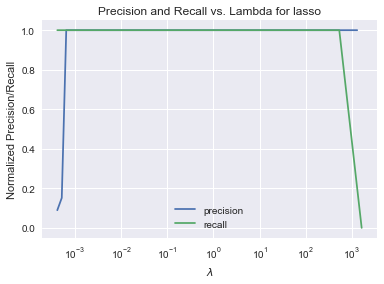

In [31]:
y,x,w_star,k = generateData()
type(y)
w_vec,num_non_zero_vec,correct_non_zero_vec,lambda_vec = lasso_loop(x,y,k)
plot_precision_recall(num_non_zero_vec,correct_non_zero_vec,lambda_vec,k)

In [11]:

lambda_val = 100
w,stop_cond_vec = lasso_CD(x,y,lambda_val)

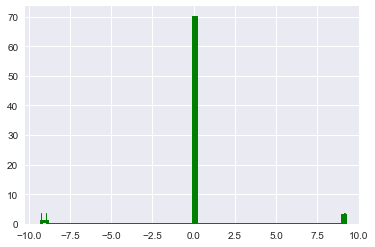

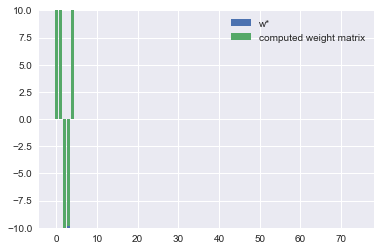

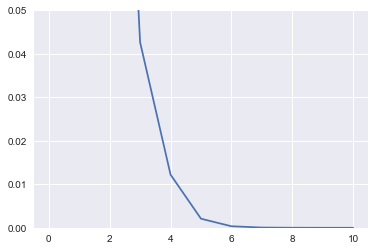

In [12]:
plot_lasso(w,stop_cond_vec,w_star)


In [34]:
np.sum([x==0 for x in w]

69

In [68]:
a = np.row_stack((w,w))

np.shape(a)

sum((x==0 for x in a.T))

(2, 75)

array([69, 69])

In [20]:
ground_truth = np.zeros((np.shape(x)[1],))
ground_truth[0:5] = 1

# total non zero 
num_non_zero = sum((x==0 for x in w))

# correct non zeros 
w_logical = w!=0

ground_truth 
correct_non_zero = sum(w_logical==ground_truth)
w_logical
print(w_logical)

array([ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [94]:
np.logical_and(ground_truth,w_logical)

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [32]:
print(num_non_zero_vec)
print(correct_non_zero_vec)

[0, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 7, 6, 6, 6, 7, 7, 11, 18, 20, 17, 26, 34, 43, 58]
[0, 1, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [50]:
print(np.abs(w_vec[167])>0)
print(np.abs(w_vec[167]))

[ True  True  True  True  True False False False  True False  True False
 False  True  True  True False False False False False  True False False
 False  True False False  True False False  True  True False  True False
 False False False  True False  True False False False False False False
 False False  True False False  True False  True False  True  True False
 False False  True  True False False False  True False False False False
 False False False]
[  1.00000000e+01   1.00000000e+01   1.00000000e+01   1.00000000e+01
   1.00000000e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.65034546e-16   0.00000000e+00   2.62064425e-16   0.00000000e+00
   0.00000000e+00   1.69814498e-17   4.04643914e-16   3.35177492e-16
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   6.50684662e-16   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.35443039e-16   0.00000000e+00   0.00000000e+00
   2.81110561e-16   0.00000000e+00   0.00000000e+00   1.523

In [23]:
mask = np.array(num_non_zero_vec)>5
mask
lambda_vec_array = np.array(lambda_vec)
lambda_vec_array


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

array([  1.28602928e+03,   1.02882342e+03,   8.23058739e+02,
         6.58446991e+02,   5.26757593e+02,   4.21406074e+02,
         3.37124860e+02,   2.69699888e+02,   2.15759910e+02,
         1.72607928e+02,   1.38086342e+02,   1.10469074e+02,
         8.83752592e+01,   7.07002073e+01,   5.65601659e+01,
         4.52481327e+01,   3.61985062e+01,   2.89588049e+01,
         2.31670439e+01,   1.85336352e+01,   1.48269081e+01,
         1.18615265e+01,   9.48922120e+00,   7.59137696e+00,
         6.07310157e+00,   4.85848125e+00,   3.88678500e+00,
         3.10942800e+00,   2.48754240e+00,   1.99003392e+00,
         1.59202714e+00,   1.27362171e+00,   1.01889737e+00,
         8.15117894e-01,   6.52094315e-01,   5.21675452e-01,
         4.17340362e-01,   3.33872290e-01,   2.67097832e-01,
         2.13678265e-01,   1.70942612e-01,   1.36754090e-01,
         1.09403272e-01,   8.75226175e-02,   7.00180940e-02,
         5.60144752e-02,   4.48115801e-02,   3.58492641e-02,
         2.86794113e-02,

In [ ]:
[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          0.83333333  0.83333333  0.625       0.55555556  0.55555556
  0.71428571  0.83333333  0.55555556  0.35714286  0.35714286  0.25
  0.11904762  0.11111111  0.11627907  0.10638298  0.10416667  0.09090909
  0.07692308  0.07246377  0.07142857  0.06849315]

In [57]:
np.shape(lambda_vec)
np.shape(correct_non_zero_vec)

(171,)

(171,)

In [23]:
a = np.array([1,2,3,4,5])
b = np.array(a)
a
b
a += 5
a
b

array([1, 2, 3, 4, 5])

array([1, 2, 3, 4, 5])

array([ 6,  7,  8,  9, 10])

array([1, 2, 3, 4, 5])

In [39]:
b = np.arange(5)
np.shape(b)

(5,)

In [20]:
lambda_vec

[1286.0292799257877,
 1028.8234239406302,
 823.05873915250413,
 658.44699132200333,
 526.75759305760266,
 421.40607444608213,
 337.12485955686572,
 269.69988764549259,
 215.75991011639408,
 172.60792809311528,
 138.08634247449223,
 110.46907397959379,
 88.375259183675041,
 70.700207346940033,
 56.560165877552031,
 45.24813270204163,
 36.198506161633304,
 28.958804929306645,
 23.167043943445318,
 18.533635154756254,
 14.826908123805005,
 11.861526499044004,
 9.4892211992352031,
 7.591376959388163,
 6.0731015675105304,
 4.8584812540084243,
 3.8867850032067395,
 3.1094280025653918,
 2.4875424020523136,
 1.990033921641851,
 1.5920271373134809,
 1.2736217098507847,
 1.0188973678806279,
 0.81511789430450232,
 0.65209431544360186,
 0.52167545235488155,
 0.41734036188390528,
 0.33387228950712422,
 0.26709783160569939,
 0.21367826528455952,
 0.17094261222764762,
 0.13675408978211809,
 0.10940327182569448,
 0.087522617460555591,
 0.070018093968444481,
 0.056014475174755586,
 0.04481158013980447,

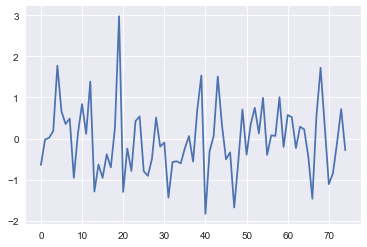

In [9]:
n = 50
d = 75
#n = 4000
#d = 6000
k = 5 
sigma = 1

# generate x_i
cov_mat = np.identity(d)
avg = np.zeros((d,))
x = np.random.multivariate_normal(avg,cov_mat,n)
x = np.random.multivariate_normal(avg,cov_mat)

np.shape(x)
plt.plot(x)

In [ ]:
def lasso_CD_vec_inner(x,w,y,w_0,k):
    n = np.shape(x)[0]
    d = np.shape(x)[1]
    
    a = 2*np.dot(x[:,k].T,x[:,k])

    # bool version
    mask = np.ones(d,dtype=bool)
    mask[k] = 0
    x_temp = x[:,mask]
    w_temp = w[mask]

    diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
    c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

    if c[k] < - lambda_val:
        w = ((c+lambda_val))/a
    elif (-lambda_val < c[k] < lambda_val):
        w[k] = 0
    elif c[k] > lambda_val:
        w[k] = ((c[k]-lambda_val))/a[k]
    
        
lasso_vectorized = np.vectorize(lasso_CD_vec_inner)

def lasso_CD_vec(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-3
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = w_init
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = y - np.dot(x,w)
        w_0 = (1/n)*np.sum(diff_y_x)
        d_range = np.arange(d)
       # for k in np.arange(d):


        weight_diff = w - w_old
        w_old = np.array(w)


        stop_cond = np.max(weight_diff)
        stop_cond_vec.append(stop_cond)
    
    return w,stop_cond_vec

In [17]:
k = np.array([1,2,3,4])
k + 4

array([5, 6, 7, 8])